In [30]:
!pip install transformers
!pip install sentencepiece
!pip install nltk
!pip install ipywidgets

In [3]:
import pandas as pd
import numpy as np
import random
import joblib
import torch

from sklearn import preprocessing
from sklearn import model_selection
# from DataAugmentation 
from data_utils import loadDatafromFile,createTokenizedDf,CompDataset,createkfoldData,createDataloaders
from data_utils_unlabelled import loadUnlabelledDatafromFile,createTokenizedDfUnlabelled,CompDatasetUnlabelled
from DataAugmentation import DataAugmentation
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup
from importlib import reload
import config
from transformers import XLMRobertaForTokenClassification, XLMRobertaConfig ,BertModel, XLMRobertaTokenizer, XLMRobertaModel, BertForTokenClassification
from seqeval.metrics import accuracy_score, classification_report
from sklearn.metrics import matthews_corrcoef,classification_report,f1_score
import engine
# from model_new import EntityModel
import torch.nn as nn
from tqdm import tqdm

In [4]:
#setting seed
torch.manual_seed(config.random_seed)
np.random.seed(config.random_seed)
random.seed(config.random_seed)

In [6]:
# config = reload(config)

In [7]:
# Read the labelled data
def process_data_labelled(filePath_src,filePath_tar, filePath_srcTags,filePath_tarTags,
                 filePath_src_eval,filePath_tar_eval, filePath_srcTags_eval,filePath_tarTags_eval,
                 model_type='xlm'):
    
    
    dataObjTrain = loadDatafromFile(filePath_src,filePath_tar, filePath_srcTags,filePath_tarTags)
    df_train= dataObjTrain.createDf() # get dataframe from files    
    dataObjEval = loadDatafromFile(filePath_src_eval,filePath_tar_eval, filePath_srcTags_eval,filePath_tarTags_eval)
    df_eval = dataObjEval.createDf()
    df_combined = df_train.append(df_eval, ignore_index=True)
    df_combined.reset_index(drop=True)
    split_ratio_len = int(len(df_combined) - config.test_split_ratio*len(df_combined))
    df_train_splitted = df_combined.iloc[:split_ratio_len,:]
    df_eval_splitted = df_combined.iloc[split_ratio_len:,:]
    obj_tokenized_train = createTokenizedDf(df_train_splitted,model_type)
    obj_tokenized_test = createTokenizedDf(df_eval_splitted,model_type)
    df_new_train = obj_tokenized_train.convertDf()
    df_new_eval = obj_tokenized_test.convertDf()
    train_data = CompDataset(df_new_train,model_type)
    test_data = CompDataset(df_new_eval,model_type)
    return train_data,test_data


In [8]:
# # Read the labelled data
# def process_data_labelled(filePath_src,filePath_tar, filePath_srcTags,filePath_tarTags,
#                  filePath_src_eval,filePath_tar_eval, filePath_srcTags_eval,filePath_tarTags_eval,
#                  model_type='xlm'):
    
    
#     dataObjTrain = loadDatafromFile(filePath_src,filePath_tar, filePath_srcTags,filePath_tarTags)
#     df_train= dataObjTrain.createDf() # get dataframe from files    
#     df_train = df_train.sample(frac=1).reset_index(drop=True)
#     df_train=df_train.iloc[:500,:]
#     dataObjEval = loadDatafromFile(filePath_src_eval,filePath_tar_eval, filePath_srcTags_eval,filePath_tarTags_eval)
#     df_eval = dataObjEval.createDf()
#     obj_tokenized_train = createTokenizedDf(df_train,model_type)
#     obj_tokenized_test = createTokenizedDf(df_eval,model_type)
#     df_new_train = obj_tokenized_train.convertDf()
#     df_new_eval = obj_tokenized_test.convertDf()
#     train_data = CompDataset(df_new_train,model_type)
#     test_data = CompDataset(df_new_eval,model_type)
#     return train_data,test_data


In [9]:
train_data , eval_data = process_data_labelled(config.filePath_src,config.filePath_tar, config.filePath_srcTags,config.filePath_tarTags,config.filePath_src_eval,config.filePath_tar_eval, config.filePath_srcTags_eval,config.filePath_tarTags_eval)

In [10]:
print(len(train_data))
print(len(eval_data))

4800
3200


In [11]:
def process_data_unlabelled(filePath_src,filePath_tar,model_type):
    
    dataObj = loadUnlabelledDatafromFile(filePath_src,filePath_tar)
    df= dataObj.createDfUnlabelled() # get dataframe from files
    df['len_src'] = df['source'].str.split().map(lambda x:len(x))
    df['len_tar'] = df['target'].str.split().map(lambda x:len(x))
    
    df = df[df.len_tar != 36]
    df = df[df.len_tar != 2]
    df = df[df.len_src != 1]
    
    df=df.iloc[:,:-2]
#     df=df.iloc[:1000,:]
    obj_tokenized = createTokenizedDfUnlabelled(df,model_type)
    df_new= obj_tokenized.convertDf()
#     enc_label = preprocessing.LabelEncoder()
#     df_new['labels']= enc_label.fit_transform(df_new['labels'])
    train_data = CompDatasetUnlabelled(df_new,model_type)
    return df,train_data


In [12]:
df_unlabelled_train, dataset_train_unlabelled = process_data_unlabelled(config.filePath_src_backtranslated,config.filePath_tar_backtranslated,model_type = 'xlm')
len(dataset_train_unlabelled)

6997

In [13]:
#combining 2 tuples --> labelled and unlabelled data 
combined_Data = train_data + dataset_train_unlabelled
len(combined_Data)

11797

In [14]:
combined_Data[11576]

(tensor([     0,    360,    903,      4,     70,  23552,      9,    112,    266,
           2199,   1840,    344,   1577,    642,   4517,      7,      4,     44,
          52231,     83,    442,    450,    756,     70,    552,   3334,      7,
            621,  27095,   4017,   2852,     58,    450,    764,     83,   2160,
            214,      5,      2,      2,    656,    360,    656,   8186,    656,
          73351,    660,    656,    122,    656, 134942,  86828,    656,   1840,
            344,    133,    656,     44, 125673,    656,    159,  21130, 162336,
          14503,    656,  36263,    656, 128723,    656,  11841,    841,   9968,
          31076,      4,     58,    656,  31005,    656,     72,    656,  96591,
          16723,      5,    656,      2,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,    

In [15]:
# dataloaders
loader_obj = createDataloaders(combined_Data,config.TRAIN_BATCH_SIZE)
train_dataloader = loader_obj.createDataloaders()
len(train_dataloader)

1475

In [16]:
loader_obj = createDataloaders(eval_data,config.VALID_BATCH_SIZE)
val_dataloader = loader_obj.createDataloaders()
len(val_dataloader)

400

In [17]:
batch = next(iter(train_dataloader))
batch # as seen, combination of labelled and unlabelled data in one training batch

[2022-02-17 13:01:27.792 pytorch-1-6-gpu-py36-ml-p3-2xlarge-aee363f24cc078bb4ee47bd46a8f:31 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2022-02-17 13:01:27.837 pytorch-1-6-gpu-py36-ml-p3-2xlarge-aee363f24cc078bb4ee47bd46a8f:31 INFO profiler_config_parser.py:102] Unable to find config at /opt/ml/input/config/profilerconfig.json. Profiler is disabled.


[tensor([[     0, 126034,   7793,  ...,      1,      1,      1],
         [     0,    581,  12877,  ...,      1,      1,      1],
         [     0,    581,    601,  ...,      1,      1,      1],
         ...,
         [     0,    209,  15360,  ...,      1,      1,      1],
         [     0,  52917,  10821,  ...,      1,      1,      1],
         [     0,   2161,     70,  ...,      1,      1,      1]]),
 tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]]),
 tensor([[-100,    1,    1,  ..., -100, -100, -100],
         [-100,    1,    1,  ..., -100, -100, -100],
         [-100,    1,    1,  ..., -100, -100, -100],
         ...,
         [-100,    1,    1,  ..., -100, -100, -100],
         [-100,    1,    1,  ..., -100, -100, -100],
         [-100, -100, -100,  ..., -100, -100, -100]])]

In [17]:
# class GaussianNoise(nn.Module):
#     """Gaussian noise regularizer.

#     Args:
#         sigma (float, optional): relative standard deviation used to generate the
#             noise. Relative means that it will be multiplied by the magnitude of
#             the value your are adding the noise to. This means that sigma can be
#             the same regardless of the scale of the vector.
#         is_relative_detach (bool, optional): whether to detach the variable before
#             computing the scale of the noise. If `False` then the scale of the noise
#             won't be seen as a constant but something to optimize: this will bias the
#             network to generate vectors with smaller values.
#     """

#     def __init__(self, sigma=0.1, is_relative_detach=True):
#         super().__init__()
#         self.sigma = sigma
#         self.is_relative_detach = is_relative_detach
#         self.noise = torch.tensor(0).to(device)

#     def forward(self, x):
#         if self.training and self.sigma != 0:
#             scale = self.sigma * x.detach() if self.is_relative_detach else self.sigma * x
#             sampled_noise = self.noise.repeat(*x.size()).normal_() * scale
#             x = x + sampled_noise
#         return x 

In [18]:
# # loss = nn.MSELoss()
# a = torch.tensor([[0.435,0.565],[0.820,0.180]])
# b = torch.tensor([[0.620,0.380],[0.545,0.455]])
# ConsistencyCost(a,b)

In [18]:
class GaussianNoise(nn.Module):
    
    def __init__(self, stddev):
        
        super().__init__()
        
        self.stddev = stddev

    def forward(self, din):
        
        if self.training:
            return din + torch.autograd.Variable(torch.randn(din.size()).cuda() * self.stddev)
        
        return din

In [19]:
class EntityModel(nn.Module):
    
    def __init__(self,std_gaussian=0.1,with_noise_layer = True, dropout_layer=False, dropout_prob = 0.3):
        
        super(EntityModel, self).__init__()
        
        self.std_gaussian = std_gaussian
        self.with_noise_layer = with_noise_layer
        self.bert = XLMRobertaModel.from_pretrained(config.BASE_MODEL,output_attentions = False, output_hidden_states = False)
        self.dropout_layer = dropout_layer
        self.dropout_prob = dropout_prob
        if self.with_noise_layer:
            self.noise = GaussianNoise(stddev=self.std_gaussian)
        if self.dropout_layer:
            self.bert_drop_1 = nn.Dropout(self.dropout_prob) # remove this or noise 
        self.out_tag = nn.Linear(768, 2)
        self.softmax = nn.Softmax(dim=2)
    
    def forward(self, ids, attention_mask):
        
        outputs = self.bert(ids,
                            attention_mask = attention_mask,
                            return_dict=False)
        
        if (self.with_noise_layer):
            
            noise = self.noise(outputs[0]) # 256*768
            
            if self.dropout_layer:
                bo_tag = self.bert_drop_1(noise)
                tag = self.out_tag(bo_tag)
            else:
                tag = self.out_tag(noise)
        
        else:
            
            if self.dropout_layer:
                bo_tag = self.bert_drop_1(outputs[0])
                tag = self.out_tag(bo_tag)
            
            else :
                tag = self.out_tag(outputs[0])
#         tag = self.out_tag(bo_tag) # 256 * 2 
       
        softmax_prob = self.softmax(tag)
        
#         loss_tag = loss_fn(tag,labels,attention_mask)
        
        return softmax_prob,tag
#         return outputs[0], outputs[1]
        

In [24]:
def ClassificationCost(output,target,mask):
    
    
    active_loss = mask.view(-1) == 1 #loss calculation for non padded tokens only (mask =1)
    active_logits = output.view(-1,2)
    
    active_labels = torch.where( # just append -100 for the padded tokens so its ignored when computing loss , no need now
        active_loss,             # since its handled in preprocessing only
        target.view(-1),
        torch.tensor(-100).type_as(target)    
    )
    try:
        class_0_weights =1/len(torch.where(active_labels==0)[0]) # trying to weight the labels as its unbalanced mostly
    
    except ZeroDivisionError:
        class_0_weights = 1e-8

    try:
        class_1_weights =1/len(torch.where(active_labels==1)[0])
    
    except ZeroDivisionError:
        class_1_weights = 1e-8
    
    weights_tensor = torch.tensor([class_0_weights,class_1_weights]).cuda()
    lfn = nn.CrossEntropyLoss(weight = weights_tensor)
    loss = lfn(active_logits,active_labels)
    
    return loss

In [148]:
a = torch.tensor([[0.2,0.5],[0.9,0.4],[0.9,0.2],[0.2,0.9],[0.7,0.4]])
b = torch.tensor([-100,-100,-100,-100,-100])
c = torch.tensor([1,1,1,1,1])
ClassificationCost(a,b,c)

1e-08 1e-08


tensor(0.)

In [26]:
def ConsistencyCost(student_output, teacher_output,mask):
    
    assert len(student_output) == len(teacher_output)
    
    loss = nn.MSELoss()
    active_outputs = mask.view(-1) == 1 #loss calculation for non padded tokens only (mask =1)
    flattened_outputs_student = student_output.view(-1,2)
    flatenned_outputs_teacher = teacher_output.view(-1,2)

    active_outputs_teacher=flatenned_outputs_teacher[torch.where(mask.view(-1) == 1)]
    active_outputs_student=flattened_outputs_student[torch.where(mask.view(-1) == 1)]
    
    return 10*loss(active_outputs_student.view(-1),active_outputs_teacher.view(-1))
    

In [27]:
import torch
import torch.nn as nn
a = torch.tensor([[0.2,0.5],[0.9,0.4],[0.9,0.2],[0.2,0.9]])
b = torch.tensor([[0.5,0.3],[0.7,0.2],[0.5,0.6],[0.7,0.2]])
c = torch.tensor([1,1,1,0])
print(ConsistencyCost(a,b,c).item())


0.8833333253860474


In [29]:
# Update teacher to be exponential moving average of student params.
def update_teacher_params(student_model, teacher_model, alpha, global_step):
    # Use the true average until the exponential average is more correct
    
    teacher_params = teacher_model.parameters()
    student_params = student_model.parameters()
    
    assert sum(p.numel() for p in student_model.parameters()) == sum(p.numel() for p in teacher_model.parameters())
    
    alpha = min(1 - 1 / (global_step + 1), alpha)
    
    for teacher_param, student_param in zip(teacher_params, student_params):
            teacher_param.data.mul_(config.alpha).add_(1 - config.alpha, student_param.data)
    
    return teacher_model 

In [56]:
# sum(p.numel() for p in model.parameters())


In [30]:
def train(train_dataloader, optimizer,scheduler, student_model, teacher_model,  epoch):
    
    student_model.train() # put student model in training mode
    total_train_loss = 0
    consistency_cst = 0
    classification_cst=0
    classification_cst_lst = []
    consistency_cst_lst = []
    overall_cst_lst = []
    global_step = 0
    
    for step, batch in enumerate(tqdm(train_dataloader, total = len(train_dataloader),position = 0 , leave = True)):

        if (student_model.training):
            
            b_input_ids = batch[0].cuda()
            b_input_mask = batch[1].cuda()
            b_labels = batch[2].cuda()
            optimizer.zero_grad()
            
            output_student_softmax, output_student_logit = student_model( b_input_ids, attention_mask = b_input_mask )
            
            with torch.no_grad():
                
                if (teacher_model.training!=True):
                    output_teacher_softmax, _ = teacher_model( b_input_ids, attention_mask = b_input_mask )
                else:
                    print('Teacher is in training mode in current epoch',epoch)
                    break

            classification_cost =  ClassificationCost(output_student_logit,b_labels,b_input_mask)
            classification_cst+=classification_cost.item()
            
            consistency_cost = ConsistencyCost(output_student_softmax,output_teacher_softmax,b_input_mask)
            consistency_cst+=consistency_cost.item()
            
            overall_cost = (config.ratio * classification_cost) + ((1 - config.ratio) * consistency_cost)
            
            overall_cost.backward()
            optimizer.step()
            scheduler.step()
            
            total_train_loss+=overall_cost.item()
            
            teacher_model = update_teacher_params(student_model , teacher_model , config.alpha,global_step)

            with torch.no_grad():
                teacher_softmax,_ = teacher_model(b_input_ids, attention_mask = b_input_mask)
            
            if step % 50 == 0 and step!=0:
                print ('train loss : ', total_train_loss/step)
                print('Consistency Cost :', consistency_cst/step)
                print('Classification Cost :', classification_cst/step)                         
        
        else:
            print('Student model is not in training mode in epoch', epoch)
#             break
        global_step+=1
    consistency_cst_lst.append(consistency_cst/len(train_dataloader))
    classification_cst_lst.append(classification_cst/len(train_dataloader))
    overall_cst_lst.append(total_train_loss/len(train_dataloader))  
        
    return (consistency_cst_lst, classification_cst_lst, overall_cst_lst)

In [31]:
def test( model, test_loader):
    
    model.eval()
    test_loss = 0
    correct = 0
    lst_active_preds = []
    lst_active_labels = []
    with torch.no_grad():
        
        for batch in tqdm(test_loader,total = len(test_loader),position = 0 , leave = True):
            
            b_input_ids_eval = batch[0].cuda()
            b_input_mask_eval = batch[1].cuda()
            b_labels_eval = batch[2].cuda()
            
            _, output= model(b_input_ids_eval,attention_mask = b_input_mask_eval)
            
            classification_cost =  ClassificationCost(output,b_labels_eval,b_input_mask_eval)
            test_loss+=classification_cost
            
            labels = b_labels_eval.view(-1) 
            active_logits = output.view(-1, 2)
            flattened_predictions = torch.argmax(active_logits, axis=1)
            active_accuracy = labels.view(-1) != -100
            labels_tmp = torch.masked_select(labels, active_accuracy) 
            pred_tmp = torch.masked_select(flattened_predictions, active_accuracy) 
            lst_active_labels.extend(labels_tmp.tolist())
            lst_active_preds.extend(pred_tmp.tolist())
            
    avg_f1_score_0=f1_score(lst_active_labels,lst_active_preds,average='binary',pos_label = 0)
    avg_f1_score_1=f1_score(lst_active_labels,lst_active_preds,average='binary',pos_label = 1)
    avg_accuracy_score=accuracy_score(lst_active_labels,lst_active_preds)
    avg_mcc_score = matthews_corrcoef(lst_active_labels,lst_active_preds)
    
    test_loss /= len(test_loader)
    
    print('Overall validation loss:', test_loss)
    print('Average F1 Validation score for whole sentence class 0 :' ,avg_f1_score_0)
    print('Average F1 Validation score for whole sentence class 1 :' ,avg_f1_score_1)
    print('Average Accuracy Validation score whole sentence  :' ,avg_accuracy_score)
    print('Average mcc Validation score whole sentence :' ,avg_mcc_score)
    print('Classification Report :'+'\n', classification_report(lst_active_labels,lst_active_preds))

    return (test_loss, avg_f1_score_0 , avg_f1_score_1, avg_accuracy_score, avg_mcc_score)

In [32]:
def train_MeanTeacher(train_dataloader, val_dataloader,noise_layer=True, dropout_layer = False):
    
    
    # train losses
    epochs_consistency_lst =[]
    epochs_classification_lst = []
    epochs_overall_lst = []
    
    #test metrices for student
    epochs_f1_score_0_lst_student = []
    epochs_f1_score_1_lst_student = []
    epochs_accuracy_lst_student = []
    epochs_mcc_lst_student = []
    epochs_cost_lst_student=[]
    
    #test metrices for teacher
    epochs_f1_score_0_lst_teacher= []
    epochs_f1_score_1_lst_teacher = []
    epochs_accuracy_lst_teacher = []
    epochs_mcc_lst_teacher = []
    epochs_cost_lst_teacher=[]
    
    #initialaize the language models
    student = EntityModel(std_gaussian=config.gaussian_noise_std_student, with_noise_layer=noise_layer, dropout_layer=dropout_layer) 
    teacher = EntityModel(std_gaussian=config.gaussian_noise_std_teacher, with_noise_layer=noise_layer)
    
    student.cuda() # take model to gpu
    teacher.cuda()
    teacher.eval()
    param_optimizer_student = list(student.named_parameters())
    param_teacher = list(teacher.named_parameters())
    
    no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
    optimizer_parameters = [
    {
        "params": [
            p for n, p in param_optimizer_student if not any(nd in n for nd in no_decay)
        ],
        "weight_decay": 0.001,
    },
    {
        "params": [
            p for n, p in param_optimizer_student if any(nd in n for nd in no_decay)
        ],
        "weight_decay": 0.0,
    },
]
    optimizer = AdamW(optimizer_parameters, lr=config.lr)
    num_train_steps = int(len(train_dataloader) * config.EPOCHS)
#     scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
#         optimizer, T_max=num_train_steps)
    scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=0, num_training_steps=num_train_steps
)
    for epoch in range(0,config.EPOCHS):
        print(f'Current epoch is {epoch+1} of {config.EPOCHS}')
        
        consistency_cost , classification_cost , overall_cost = train(train_dataloader, optimizer,scheduler,student,teacher,epoch)
        
        epochs_consistency_lst.append(consistency_cost)
        epochs_classification_lst.append(classification_cost)
        epochs_overall_lst.append(overall_cost)
        
        print('---------Running validation for student -------------')
        test_loss_student, avg_f1_score_0_student, avg_f1_score_1_student, avg_accuracy_score_student, avg_mcc_score_student = test(student,val_dataloader)
        
        epochs_f1_score_0_lst_student.append(avg_f1_score_0_student)
        epochs_f1_score_1_lst_student.append(avg_f1_score_1_student)
        epochs_accuracy_lst_student.append(avg_accuracy_score_student)
        epochs_mcc_lst_student.append(avg_mcc_score_student)
        epochs_cost_lst_student.append(test_loss_student)
        
        print('---------Running validation for teacher -------------')

        test_loss_teacher, avg_f1_score_0_teacher, avg_f1_score_1_teacher, avg_accuracy_score_teacher, avg_mcc_score_teacher=test(teacher,val_dataloader)
        
        epochs_f1_score_0_lst_teacher.append(avg_f1_score_1_teacher)
        epochs_f1_score_1_lst_teacher.append(avg_f1_score_0_teacher)
        epochs_accuracy_lst_teacher.append(avg_accuracy_score_teacher)
        epochs_mcc_lst_teacher.append(avg_mcc_score_teacher)
        epochs_cost_lst_teacher.append(test_loss_teacher)
        
#         break
        
        
    return (epochs_consistency_lst,epochs_classification_lst,epochs_overall_lst,epochs_f1_score_0_lst_student,epochs_f1_score_1_lst_student,
           epochs_accuracy_lst_student,epochs_mcc_lst_student,epochs_cost_lst_student,epochs_f1_score_0_lst_teacher,epochs_f1_score_1_lst_teacher,
            epochs_accuracy_lst_teacher,epochs_mcc_lst_teacher,epochs_cost_lst_teacher)

<h2> without weighted classification cost - with Noise - without dropout </h2>

In [61]:
metrices = train_MeanTeacher(train_dataloader,val_dataloader,noise_layer=True) # alpha = 0.995 and full data with noise and w/o dropout
print('Consistency_lost_train :',metrices[0],'\n','Classificataion_lost_train : ',metrices[1],'\n','Overall_loss_train :',metrices[2],'\n',
      'f1_class0_student_test :',metrices[3],'\n','f1_class1_student_test :',metrices[4],'\n','accuracy_student :',metrices[5],'\n','mcc_cost_student :',metrices[6],
      '\n','test_cost_student :',metrices[7],'\n','f1_class0_teacher_test :',metrices[8],'\n','f1_class1_teacher_test :',metrices[9],'\n',
    'accuracy_teacher :', metrices[10],'\n','mcc_cost_teacher',metrices[11],'\n','test_cost_teacher',metrices[12])

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaModel: ['lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaModel: ['lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight']
- This IS expected if you are ini

Current epoch is 1 of 6


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  /codebuild/output/src811146734/src/torch/csrc/utils/python_arg_parser.cpp:766.)
  del sys.path[0]
  3%|▎         | 51/1475 [00:31<14:58,  1.58it/s]

train loss :  0.2920157599449158
Consistency Cost : 0.12211377955973149
Classification Cost : 0.4619177380204201


  7%|▋         | 101/1475 [01:03<14:48,  1.55it/s]

train loss :  0.27036710843443873
Consistency Cost : 0.09794396448880434
Classification Cost : 0.4427902503311634


 10%|█         | 151/1475 [01:36<14:31,  1.52it/s]

train loss :  0.2556134384870529
Consistency Cost : 0.08304985461135705
Classification Cost : 0.4281770211458206


 14%|█▎        | 201/1475 [02:09<14:11,  1.50it/s]

train loss :  0.23714423509314655
Consistency Cost : 0.07435021691024303
Classification Cost : 0.3999382524192333


 17%|█▋        | 251/1475 [02:43<13:57,  1.46it/s]

train loss :  0.229057481944561
Consistency Cost : 0.06443319586664438
Classification Cost : 0.3936817668676376


 20%|██        | 301/1475 [03:17<13:21,  1.46it/s]

train loss :  0.22419390770296255
Consistency Cost : 0.05710310551337898
Classification Cost : 0.39128470892707506


 24%|██▍       | 351/1475 [03:51<12:47,  1.47it/s]

train loss :  0.21780252531436936
Consistency Cost : 0.05116686809541924
Classification Cost : 0.38443818151950837


 27%|██▋       | 401/1475 [04:25<12:14,  1.46it/s]

train loss :  0.21545040166238322
Consistency Cost : 0.047681810455396774
Classification Cost : 0.383218991830945


 31%|███       | 451/1475 [04:59<11:39,  1.46it/s]

train loss :  0.2114437905471358
Consistency Cost : 0.044007382730229035
Classification Cost : 0.37888019720713295


 34%|███▍      | 501/1475 [05:34<11:07,  1.46it/s]

train loss :  0.20804717661999167
Consistency Cost : 0.04096882551535964
Classification Cost : 0.37512552678585054


 37%|███▋      | 551/1475 [06:08<10:34,  1.46it/s]

train loss :  0.2055562951398844
Consistency Cost : 0.038503225418654356
Classification Cost : 0.37260936374014075


 41%|████      | 601/1475 [06:42<09:58,  1.46it/s]

train loss :  0.20400534658692776
Consistency Cost : 0.03630163878047218
Classification Cost : 0.3717090534542998


 44%|████▍     | 651/1475 [07:16<09:24,  1.46it/s]

train loss :  0.20077362051663492
Consistency Cost : 0.034531650375574825
Classification Cost : 0.3670155898653544


 48%|████▊     | 701/1475 [07:50<08:48,  1.46it/s]

train loss :  0.19895629946608095
Consistency Cost : 0.03304554823253836
Classification Cost : 0.364867049955896


 51%|█████     | 751/1475 [08:25<08:15,  1.46it/s]

train loss :  0.1972683510798961
Consistency Cost : 0.031667745728045704
Classification Cost : 0.36286895562211674


 54%|█████▍    | 801/1475 [08:59<07:40,  1.46it/s]

train loss :  0.19606582018721383
Consistency Cost : 0.03044711292721331
Classification Cost : 0.36168452659621836


 58%|█████▊    | 851/1475 [09:33<07:07,  1.46it/s]

train loss :  0.19462986620143055
Consistency Cost : 0.029301973236176896
Classification Cost : 0.35995775831972854


 61%|██████    | 901/1475 [10:07<06:32,  1.46it/s]

train loss :  0.1944362679962069
Consistency Cost : 0.028370218282151555
Classification Cost : 0.36050231696003016


 64%|██████▍   | 951/1475 [10:41<05:57,  1.46it/s]

train loss :  0.19259576770035844
Consistency Cost : 0.027403883064459813
Classification Cost : 0.35778765154512304


 68%|██████▊   | 1001/1475 [11:16<05:24,  1.46it/s]

train loss :  0.19110013258084654
Consistency Cost : 0.026565704292617738
Classification Cost : 0.3556345601379871


 71%|███████▏  | 1051/1475 [11:50<04:49,  1.46it/s]

train loss :  0.19039089697590542
Consistency Cost : 0.02579874342529192
Classification Cost : 0.35498304987237567


 75%|███████▍  | 1101/1475 [12:24<04:15,  1.46it/s]

train loss :  0.18988577505192636
Consistency Cost : 0.025126837680793622
Classification Cost : 0.3546447117288004


 78%|███████▊  | 1151/1475 [12:58<03:41,  1.46it/s]

train loss :  0.1889017626558147
Consistency Cost : 0.024537784355166167
Classification Cost : 0.35326574036284636


 81%|████████▏ | 1201/1475 [13:32<03:07,  1.46it/s]

train loss :  0.1878497375183118
Consistency Cost : 0.023936027427747225
Classification Cost : 0.35176344704503815


 85%|████████▍ | 1251/1475 [14:07<02:33,  1.46it/s]

train loss :  0.18776014084517956
Consistency Cost : 0.023392095291614533
Classification Cost : 0.35212818589806555


 88%|████████▊ | 1301/1475 [14:41<01:58,  1.46it/s]

train loss :  0.18679646626401405
Consistency Cost : 0.02282489656112515
Classification Cost : 0.35076803549551044


 92%|█████████▏| 1351/1475 [15:15<01:24,  1.46it/s]

train loss :  0.1859076963447862
Consistency Cost : 0.02231399722431821
Classification Cost : 0.349501394999248


 95%|█████████▍| 1401/1475 [15:49<00:50,  1.46it/s]

train loss :  0.18497331592221078
Consistency Cost : 0.021824642799994243
Classification Cost : 0.3481219885711159


 98%|█████████▊| 1451/1475 [16:24<00:16,  1.46it/s]

train loss :  0.18420696363463226
Consistency Cost : 0.021388765798624733
Classification Cost : 0.347025160979608


  0%|          | 0/400 [00:00<?, ?it/s]

---------Running validation for student -------------


100%|██████████| 400/400 [00:46<00:00,  8.67it/s]


Overall validation loss: tensor(0.3101, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.049021276595744685
Average F1 Validation score for whole sentence class 1 : 0.9330858135217678
Average Accuracy Validation score whole sentence  : 0.8749692290477789
Average mcc Validation score whole sentence : 0.11091686612715324


  0%|          | 0/400 [00:00<?, ?it/s]

Classification Report :
               precision    recall  f1-score   support

           0       0.65      0.03      0.05     28264
           1       0.88      1.00      0.93    195161

    accuracy                           0.87    223425
   macro avg       0.76      0.51      0.49    223425
weighted avg       0.85      0.87      0.82    223425

---------Running validation for teacher -------------


100%|██████████| 400/400 [00:46<00:00,  8.68it/s]


Overall validation loss: tensor(0.3162, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.004726964865246225
Average F1 Validation score for whole sentence class 1 : 0.932583356829836
Average Accuracy Validation score whole sentence  : 0.8737204878594607
Average mcc Validation score whole sentence : 0.039153562243505295


  0%|          | 0/1475 [00:00<?, ?it/s]

Classification Report :
               precision    recall  f1-score   support

           0       0.80      0.00      0.00     28264
           1       0.87      1.00      0.93    195161

    accuracy                           0.87    223425
   macro avg       0.84      0.50      0.47    223425
weighted avg       0.86      0.87      0.82    223425

Current epoch is 2 of 6


  3%|▎         | 51/1475 [00:34<16:14,  1.46it/s]

train loss :  0.17259153351187706
Consistency Cost : 0.009171052491292358
Classification Cost : 0.33601201117038726


  7%|▋         | 101/1475 [01:09<15:40,  1.46it/s]

train loss :  0.17130960269365458
Consistency Cost : 0.009641253110021352
Classification Cost : 0.33297794982790946


 10%|█         | 151/1475 [01:43<15:07,  1.46it/s]

train loss :  0.1672524958755821
Consistency Cost : 0.009102491214871406
Classification Cost : 0.3254024990399679


 14%|█▎        | 201/1475 [02:17<14:34,  1.46it/s]

train loss :  0.16339776610257103
Consistency Cost : 0.008951377808116376
Classification Cost : 0.31784415293484924


 17%|█▋        | 251/1475 [02:51<13:58,  1.46it/s]

train loss :  0.16034576003067194
Consistency Cost : 0.008977956188842654
Classification Cost : 0.31171356260031463


 20%|██        | 301/1475 [03:26<13:24,  1.46it/s]

train loss :  0.15732155460553865
Consistency Cost : 0.008794871914821367
Classification Cost : 0.3058482361150285


 24%|██▍       | 351/1475 [04:00<12:48,  1.46it/s]

train loss :  0.15760297650870467
Consistency Cost : 0.00886608438566327
Classification Cost : 0.30633986750351533


 27%|██▋       | 401/1475 [04:34<12:16,  1.46it/s]

train loss :  0.15663958525983618
Consistency Cost : 0.008671752590453252
Classification Cost : 0.3046074168244377


 31%|███       | 451/1475 [05:08<11:40,  1.46it/s]

train loss :  0.15652376448321673
Consistency Cost : 0.00856240641636153
Classification Cost : 0.3044851215721832


 34%|███▍      | 501/1475 [05:43<11:04,  1.46it/s]

train loss :  0.15414557320065797
Consistency Cost : 0.008270724368747324
Classification Cost : 0.3000204211510718


 37%|███▋      | 551/1475 [06:17<10:32,  1.46it/s]

train loss :  0.1540752543932335
Consistency Cost : 0.008193515646271408
Classification Cost : 0.29995699227194894


 41%|████      | 601/1475 [06:51<09:57,  1.46it/s]

train loss :  0.15427160332755496
Consistency Cost : 0.008183396698053305
Classification Cost : 0.3003598092403263


 44%|████▍     | 651/1475 [07:25<09:24,  1.46it/s]

train loss :  0.15402246260728975
Consistency Cost : 0.008025571178071775
Classification Cost : 0.30001935340177555


 48%|████▊     | 701/1475 [08:00<08:51,  1.46it/s]

train loss :  0.15386288558132946
Consistency Cost : 0.00791571883418198
Classification Cost : 0.29981005171846065


 51%|█████     | 751/1475 [08:34<08:15,  1.46it/s]

train loss :  0.15514175304149588
Consistency Cost : 0.007840353831027946
Classification Cost : 0.3024431516552965


 54%|█████▍    | 801/1475 [09:08<07:43,  1.45it/s]

train loss :  0.1557997699608677
Consistency Cost : 0.007839272939017974
Classification Cost : 0.3037602664087899


 58%|█████▊    | 851/1475 [09:42<07:06,  1.46it/s]

train loss :  0.1560570066676968
Consistency Cost : 0.007747825102551895
Classification Cost : 0.3043661876921268


 61%|██████    | 901/1475 [10:16<06:34,  1.46it/s]

train loss :  0.15693226072581537
Consistency Cost : 0.0076703190348214574
Classification Cost : 0.3061942018340859


 64%|██████▍   | 951/1475 [10:51<05:59,  1.46it/s]

train loss :  0.15599908305960095
Consistency Cost : 0.007504428847214991
Classification Cost : 0.30449373672471236


 68%|██████▊   | 1001/1475 [11:25<05:25,  1.46it/s]

train loss :  0.15593808245114632
Consistency Cost : 0.007388347176194657
Classification Cost : 0.30448781727068125


 71%|███████▏  | 1051/1475 [11:59<04:50,  1.46it/s]

train loss :  0.1554720679334908
Consistency Cost : 0.007273389873305513
Classification Cost : 0.303670745610836


 75%|███████▍  | 1101/1475 [12:33<04:16,  1.46it/s]

train loss :  0.15542544559483015
Consistency Cost : 0.007128244927787984
Classification Cost : 0.3037226459028369


 78%|███████▊  | 1151/1475 [13:08<03:42,  1.46it/s]

train loss :  0.1557243561857309
Consistency Cost : 0.0070773301498316555
Classification Cost : 0.3043713818863034


 81%|████████▏ | 1201/1475 [13:42<03:08,  1.46it/s]

train loss :  0.15518633832247966
Consistency Cost : 0.0069787746417568994
Classification Cost : 0.30339390169363467


 85%|████████▍ | 1251/1475 [14:16<02:33,  1.46it/s]

train loss :  0.15520616174368188
Consistency Cost : 0.006873944662790746
Classification Cost : 0.30353837857693433


 88%|████████▊ | 1301/1475 [14:50<01:59,  1.46it/s]

train loss :  0.1549735985982429
Consistency Cost : 0.0067969968068288065
Classification Cost : 0.3031502000686641


 92%|█████████▏| 1351/1475 [15:25<01:25,  1.46it/s]

train loss :  0.15511247458828922
Consistency Cost : 0.006828290587636056
Classification Cost : 0.3033966582061516


 95%|█████████▍| 1401/1475 [15:59<00:50,  1.46it/s]

train loss :  0.15521609575770395
Consistency Cost : 0.0067608190572354945
Classification Cost : 0.30367137207383554


 98%|█████████▊| 1451/1475 [16:33<00:16,  1.46it/s]

train loss :  0.15526692622937344
Consistency Cost : 0.006737382885486145
Classification Cost : 0.30379646923136094


  0%|          | 0/400 [00:00<?, ?it/s]

---------Running validation for student -------------


100%|██████████| 400/400 [00:46<00:00,  8.66it/s]


Overall validation loss: tensor(0.3119, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.16014932337844143
Average F1 Validation score for whole sentence class 1 : 0.9349007125547075
Average Accuracy Validation score whole sentence  : 0.8791675058744545
Average mcc Validation score whole sentence : 0.21467604355071182


  0%|          | 0/400 [00:00<?, ?it/s]

Classification Report :
               precision    recall  f1-score   support

           0       0.66      0.09      0.16     28264
           1       0.88      0.99      0.93    195161

    accuracy                           0.88    223425
   macro avg       0.77      0.54      0.55    223425
weighted avg       0.86      0.88      0.84    223425

---------Running validation for teacher -------------


100%|██████████| 400/400 [00:46<00:00,  8.68it/s]


Overall validation loss: tensor(0.3096, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.18258803460460582
Average F1 Validation score for whole sentence class 1 : 0.9351870190472971
Average Accuracy Validation score whole sentence  : 0.8798970571780239
Average mcc Validation score whole sentence : 0.2303095748981721


  0%|          | 0/1475 [00:00<?, ?it/s]

Classification Report :
               precision    recall  f1-score   support

           0       0.66      0.11      0.18     28264
           1       0.88      0.99      0.94    195161

    accuracy                           0.88    223425
   macro avg       0.77      0.55      0.56    223425
weighted avg       0.86      0.88      0.84    223425

Current epoch is 3 of 6


  3%|▎         | 51/1475 [00:34<16:17,  1.46it/s]

train loss :  0.15582989316433668
Consistency Cost : 0.004344486435875297
Classification Cost : 0.30731530010700225


  7%|▋         | 101/1475 [01:09<15:43,  1.46it/s]

train loss :  0.15219980077818035
Consistency Cost : 0.0048903681494994085
Classification Cost : 0.2995092339813709


 10%|█         | 151/1475 [01:43<15:09,  1.46it/s]

train loss :  0.14087349792011084
Consistency Cost : 0.004865146681355933
Classification Cost : 0.2768818501879772


 14%|█▎        | 201/1475 [02:17<14:31,  1.46it/s]

train loss :  0.14177853656699882
Consistency Cost : 0.004844655246706679
Classification Cost : 0.2787124183960259


 17%|█▋        | 251/1475 [02:51<13:57,  1.46it/s]

train loss :  0.1409304646011442
Consistency Cost : 0.004903445538366214
Classification Cost : 0.2769574838280678


 20%|██        | 301/1475 [03:26<13:24,  1.46it/s]

train loss :  0.13870528589691578
Consistency Cost : 0.004991304611321539
Classification Cost : 0.27241926747684675


 24%|██▍       | 351/1475 [04:00<12:49,  1.46it/s]

train loss :  0.13715437931998167
Consistency Cost : 0.0048469594225753095
Classification Cost : 0.2694617996524487


 27%|██▋       | 401/1475 [04:34<12:17,  1.46it/s]

train loss :  0.13811968334302946
Consistency Cost : 0.005021438773983391
Classification Cost : 0.27121792823541907


 31%|███       | 451/1475 [05:08<11:42,  1.46it/s]

train loss :  0.1370884349362071
Consistency Cost : 0.004975626283299385
Classification Cost : 0.26920124378883176


 34%|███▍      | 501/1475 [05:43<11:09,  1.45it/s]

train loss :  0.1379468115567579
Consistency Cost : 0.00520069410733413
Classification Cost : 0.2706929291673005


 37%|███▋      | 551/1475 [06:17<10:33,  1.46it/s]

train loss :  0.13783620781175243
Consistency Cost : 0.005197097450621765
Classification Cost : 0.2704753183200955


 41%|████      | 601/1475 [06:51<09:57,  1.46it/s]

train loss :  0.13710437933763994
Consistency Cost : 0.005143554565923599
Classification Cost : 0.26906520426583785


 44%|████▍     | 651/1475 [07:25<09:24,  1.46it/s]

train loss :  0.136285591104041
Consistency Cost : 0.005055438338313251
Classification Cost : 0.26751574410555456


 48%|████▊     | 701/1475 [08:00<08:50,  1.46it/s]

train loss :  0.1369941298970038
Consistency Cost : 0.005096610520434167
Classification Cost : 0.2688916494511068


 51%|█████     | 751/1475 [08:34<08:15,  1.46it/s]

train loss :  0.13707055383800373
Consistency Cost : 0.005134504447846363
Classification Cost : 0.26900660335520904


 54%|█████▍    | 801/1475 [09:08<07:41,  1.46it/s]

train loss :  0.13679828317883222
Consistency Cost : 0.0051231547887437045
Classification Cost : 0.26847341168671846


 58%|█████▊    | 851/1475 [09:42<07:07,  1.46it/s]

train loss :  0.1369051143991665
Consistency Cost : 0.00510542212471859
Classification Cost : 0.2687048067459289


 61%|██████    | 901/1475 [10:17<06:32,  1.46it/s]

train loss :  0.1363919451132339
Consistency Cost : 0.005089043224514979
Classification Cost : 0.2676948471501884


 64%|██████▍   | 951/1475 [10:51<05:58,  1.46it/s]

train loss :  0.13632727896304506
Consistency Cost : 0.005111079372306306
Classification Cost : 0.26754347866008943


 68%|██████▊   | 1001/1475 [11:25<05:24,  1.46it/s]

train loss :  0.13625417327330797
Consistency Cost : 0.005112430721521378
Classification Cost : 0.26739591591153294


 71%|███████▏  | 1051/1475 [11:59<04:50,  1.46it/s]

train loss :  0.1367213942075891
Consistency Cost : 0.005130476442697857
Classification Cost : 0.26831231207276385


 75%|███████▍  | 1101/1475 [12:34<04:16,  1.46it/s]

train loss :  0.13656364523538453
Consistency Cost : 0.005081453638743948
Classification Cost : 0.2680458368589594


 78%|███████▊  | 1151/1475 [13:08<03:42,  1.46it/s]

train loss :  0.1371230023611165
Consistency Cost : 0.005479771630717036
Classification Cost : 0.2687662331395499


 81%|████████▏ | 1201/1475 [13:42<03:07,  1.46it/s]

train loss :  0.13703168592975998
Consistency Cost : 0.005556943877988185
Classification Cost : 0.26850642811429376


 85%|████████▍ | 1251/1475 [14:16<02:33,  1.46it/s]

train loss :  0.13663410485188943
Consistency Cost : 0.005599621289782226
Classification Cost : 0.26766858847364783


 88%|████████▊ | 1301/1475 [14:50<01:59,  1.46it/s]

train loss :  0.13649808640329866
Consistency Cost : 0.0056032022060110015
Classification Cost : 0.2673929706065414


 92%|█████████▏| 1351/1475 [15:25<01:24,  1.46it/s]

train loss :  0.1363034066175654
Consistency Cost : 0.005566194062034979
Classification Cost : 0.2670406191844355


 95%|█████████▍| 1401/1475 [15:59<00:50,  1.46it/s]

train loss :  0.1359450562048005
Consistency Cost : 0.005552867479896772
Classification Cost : 0.2663372449330719


 98%|█████████▊| 1451/1475 [16:33<00:16,  1.46it/s]

train loss :  0.1356031333240038
Consistency Cost : 0.005538594861121463
Classification Cost : 0.2656676717051144


  0%|          | 0/400 [00:00<?, ?it/s]

---------Running validation for student -------------


100%|██████████| 400/400 [00:46<00:00,  8.63it/s]


Overall validation loss: tensor(0.3366, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.27872357701572525
Average F1 Validation score for whole sentence class 1 : 0.9349870579137015
Average Accuracy Validation score whole sentence  : 0.8807250755287009
Average mcc Validation score whole sentence : 0.2821898434785807


  0%|          | 0/400 [00:00<?, ?it/s]

Classification Report :
               precision    recall  f1-score   support

           0       0.59      0.18      0.28     28264
           1       0.89      0.98      0.93    195161

    accuracy                           0.88    223425
   macro avg       0.74      0.58      0.61    223425
weighted avg       0.85      0.88      0.85    223425

---------Running validation for teacher -------------


100%|██████████| 400/400 [00:46<00:00,  8.66it/s]


Overall validation loss: tensor(0.3293, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.25579500435503355
Average F1 Validation score for whole sentence class 1 : 0.9355953304365376
Average Accuracy Validation score whole sentence  : 0.8814501510574018
Average mcc Validation score whole sentence : 0.2740634967010711


  0%|          | 0/1475 [00:00<?, ?it/s]

Classification Report :
               precision    recall  f1-score   support

           0       0.62      0.16      0.26     28264
           1       0.89      0.99      0.94    195161

    accuracy                           0.88    223425
   macro avg       0.76      0.57      0.60    223425
weighted avg       0.86      0.88      0.85    223425

Current epoch is 4 of 6


  3%|▎         | 51/1475 [00:34<16:18,  1.46it/s]

train loss :  0.10975414164364337
Consistency Cost : 0.005136605706065893
Classification Cost : 0.21437167704105378


  7%|▋         | 101/1475 [01:09<15:39,  1.46it/s]

train loss :  0.11020818299701204
Consistency Cost : 0.004880702484515495
Classification Cost : 0.21553566310554742


 10%|█         | 151/1475 [01:43<15:05,  1.46it/s]

train loss :  0.11243063764083976
Consistency Cost : 0.005041702835975836
Classification Cost : 0.2198195725431045


 14%|█▎        | 201/1475 [02:17<14:31,  1.46it/s]

train loss :  0.11594823544015526
Consistency Cost : 0.004892675123701337
Classification Cost : 0.22700379576534033


 17%|█▋        | 251/1475 [02:51<13:59,  1.46it/s]

train loss :  0.11612138252065052
Consistency Cost : 0.005242524153320119
Classification Cost : 0.22700024105608463


 20%|██        | 301/1475 [03:26<13:22,  1.46it/s]

train loss :  0.11533325292936449
Consistency Cost : 0.005332052972516976
Classification Cost : 0.22533445306122302


 24%|██▍       | 351/1475 [04:00<12:49,  1.46it/s]

train loss :  0.11616302212301109
Consistency Cost : 0.005151901270562251
Classification Cost : 0.22717414319515228


 27%|██▋       | 401/1475 [04:34<12:16,  1.46it/s]

train loss :  0.11744694036024157
Consistency Cost : 0.005324725668469909
Classification Cost : 0.22956915533170105


 31%|███       | 451/1475 [05:08<11:41,  1.46it/s]

train loss :  0.11806211976179232
Consistency Cost : 0.005424795808374054
Classification Cost : 0.23069944375918972


 34%|███▍      | 501/1475 [05:43<11:06,  1.46it/s]

train loss :  0.11733565480995457
Consistency Cost : 0.005348968628328294
Classification Cost : 0.2293223410397768


 37%|███▋      | 551/1475 [06:17<10:32,  1.46it/s]

train loss :  0.11720914570773444
Consistency Cost : 0.005317279357166791
Classification Cost : 0.22910101201046598


 41%|████      | 601/1475 [06:51<09:59,  1.46it/s]

train loss :  0.1178258716656031
Consistency Cost : 0.005254991359057991
Classification Cost : 0.23039675187629957


 44%|████▍     | 651/1475 [07:25<09:24,  1.46it/s]

train loss :  0.11773838081374728
Consistency Cost : 0.0051921263778618035
Classification Cost : 0.23028463524981188


 48%|████▊     | 701/1475 [08:00<08:49,  1.46it/s]

train loss :  0.11794760822497274
Consistency Cost : 0.005246113854975972
Classification Cost : 0.23064910263621383


 51%|█████     | 751/1475 [08:34<08:15,  1.46it/s]

train loss :  0.11818367516965372
Consistency Cost : 0.005274703383174104
Classification Cost : 0.23109264711290597


 54%|█████▍    | 801/1475 [09:08<07:41,  1.46it/s]

train loss :  0.11831312900003468
Consistency Cost : 0.00529628232910909
Classification Cost : 0.2313299759081565


 58%|█████▊    | 851/1475 [09:42<07:06,  1.46it/s]

train loss :  0.11892158505587277
Consistency Cost : 0.0052672874861437935
Classification Cost : 0.2325758828244665


 61%|██████    | 901/1475 [10:17<06:33,  1.46it/s]

train loss :  0.11870674677372639
Consistency Cost : 0.005240202182936224
Classification Cost : 0.2321732915027274


 64%|██████▍   | 951/1475 [10:51<05:59,  1.46it/s]

train loss :  0.11787937418972816
Consistency Cost : 0.005168036561624735
Classification Cost : 0.23059071200066492


 68%|██████▊   | 1001/1475 [11:25<05:24,  1.46it/s]

train loss :  0.1173065416476893
Consistency Cost : 0.005185592043650104
Classification Cost : 0.22942749140784144


 71%|███████▏  | 1051/1475 [11:59<04:50,  1.46it/s]

train loss :  0.11691802885176869
Consistency Cost : 0.005157648969879596
Classification Cost : 0.22867840882035947


 75%|███████▍  | 1101/1475 [12:34<04:15,  1.46it/s]

train loss :  0.11671023428115983
Consistency Cost : 0.0051759406284757215
Classification Cost : 0.2282445279356431


 78%|███████▊  | 1151/1475 [13:08<03:41,  1.46it/s]

train loss :  0.11677408646279692
Consistency Cost : 0.005231172638798497
Classification Cost : 0.22831700026017168


 81%|████████▏ | 1201/1475 [13:42<03:07,  1.46it/s]

train loss :  0.11641688107366159
Consistency Cost : 0.0052384956914223344
Classification Cost : 0.22759526640720046


 85%|████████▍ | 1251/1475 [14:16<02:33,  1.46it/s]

train loss :  0.1161394780141185
Consistency Cost : 0.005208491261606105
Classification Cost : 0.22707046475186943


 88%|████████▊ | 1301/1475 [14:51<01:59,  1.46it/s]

train loss :  0.11630361165601734
Consistency Cost : 0.005215998317647833
Classification Cost : 0.22739122494696998


 92%|█████████▏| 1351/1475 [15:25<01:25,  1.46it/s]

train loss :  0.11654516660678416
Consistency Cost : 0.0052295645019168864
Classification Cost : 0.22786076872782024


 95%|█████████▍| 1401/1475 [15:59<00:50,  1.46it/s]

train loss :  0.11611015955486177
Consistency Cost : 0.0051934034974172915
Classification Cost : 0.2270269156323879


 98%|█████████▊| 1451/1475 [16:33<00:16,  1.45it/s]

train loss :  0.11590036671087828
Consistency Cost : 0.005169579109943729
Classification Cost : 0.22663115431426156


  0%|          | 0/400 [00:00<?, ?it/s]

---------Running validation for student -------------


100%|██████████| 400/400 [00:46<00:00,  8.65it/s]


Overall validation loss: tensor(0.3790, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.26795159369721133
Average F1 Validation score for whole sentence class 1 : 0.9356403945084348
Average Accuracy Validation score whole sentence  : 0.8816828913505651
Average mcc Validation score whole sentence : 0.28125344408795167


  0%|          | 0/400 [00:00<?, ?it/s]

Classification Report :
               precision    recall  f1-score   support

           0       0.62      0.17      0.27     28264
           1       0.89      0.98      0.94    195161

    accuracy                           0.88    223425
   macro avg       0.75      0.58      0.60    223425
weighted avg       0.86      0.88      0.85    223425

---------Running validation for teacher -------------


100%|██████████| 400/400 [00:46<00:00,  8.67it/s]


Overall validation loss: tensor(0.3599, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.28102776491103787
Average F1 Validation score for whole sentence class 1 : 0.9356648437519048
Average Accuracy Validation score whole sentence  : 0.8818977285442542
Average mcc Validation score whole sentence : 0.2888736091804686


  0%|          | 0/1475 [00:00<?, ?it/s]

Classification Report :
               precision    recall  f1-score   support

           0       0.61      0.18      0.28     28264
           1       0.89      0.98      0.94    195161

    accuracy                           0.88    223425
   macro avg       0.75      0.58      0.61    223425
weighted avg       0.86      0.88      0.85    223425

Current epoch is 5 of 6


  3%|▎         | 51/1475 [00:34<16:13,  1.46it/s]

train loss :  0.08272884535021148
Consistency Cost : 0.0037819027388468385
Classification Cost : 0.16167578803375363


  7%|▋         | 101/1475 [01:09<15:40,  1.46it/s]

train loss :  0.09258502991928254
Consistency Cost : 0.0043365371268009765
Classification Cost : 0.18083352216519416


 10%|█         | 151/1475 [01:43<15:07,  1.46it/s]

train loss :  0.09198780189733952
Consistency Cost : 0.004342372441897169
Classification Cost : 0.17963323067252834


 14%|█▎        | 201/1475 [02:17<14:33,  1.46it/s]

train loss :  0.09725244552013464
Consistency Cost : 0.004531161728373263
Classification Cost : 0.1899737284751609


 17%|█▋        | 251/1475 [02:51<13:57,  1.46it/s]

train loss :  0.09760727190691977
Consistency Cost : 0.004572269616881386
Classification Cost : 0.19064227357879282


 20%|██        | 301/1475 [03:26<13:22,  1.46it/s]

train loss :  0.09964092438186829
Consistency Cost : 0.004578227013310728
Classification Cost : 0.19470362132415175


 24%|██▍       | 351/1475 [04:00<12:50,  1.46it/s]

train loss :  0.10031118215568963
Consistency Cost : 0.004622386485404734
Classification Cost : 0.1959999774449638


 27%|██▋       | 401/1475 [04:34<12:14,  1.46it/s]

train loss :  0.10115078932816686
Consistency Cost : 0.004728150996088516
Classification Cost : 0.19757342723663895


 31%|███       | 451/1475 [05:08<11:41,  1.46it/s]

train loss :  0.1004794167497635
Consistency Cost : 0.0047964105661958455
Classification Cost : 0.19616242251565888


 34%|███▍      | 501/1475 [05:42<11:08,  1.46it/s]

train loss :  0.10177830656041624
Consistency Cost : 0.0048124461139086635
Classification Cost : 0.19874416677746923


 37%|███▋      | 551/1475 [06:17<10:32,  1.46it/s]

train loss :  0.10074458030205939
Consistency Cost : 0.004827435046688399
Classification Cost : 0.19666172528724102


 41%|████      | 601/1475 [06:51<09:59,  1.46it/s]

train loss :  0.10076920656618313
Consistency Cost : 0.004909050128189847
Classification Cost : 0.1966293627419509


 44%|████▍     | 651/1475 [07:25<09:25,  1.46it/s]

train loss :  0.10062564359489792
Consistency Cost : 0.004932016412046953
Classification Cost : 0.19631927044345782


 48%|████▊     | 701/1475 [07:59<08:50,  1.46it/s]

train loss :  0.0996287017772972
Consistency Cost : 0.0049550977378385146
Classification Cost : 0.19430230550401445


 51%|█████     | 751/1475 [08:34<08:16,  1.46it/s]

train loss :  0.10060841725595916
Consistency Cost : 0.00498134269619671
Classification Cost : 0.19623549146888156


 54%|█████▍    | 801/1475 [09:08<07:41,  1.46it/s]

train loss :  0.10032647209736752
Consistency Cost : 0.004976226184371626
Classification Cost : 0.19567671765980776


 58%|█████▊    | 851/1475 [09:42<07:07,  1.46it/s]

train loss :  0.10028448848409907
Consistency Cost : 0.005003758263294859
Classification Cost : 0.19556521841653568


 61%|██████    | 901/1475 [10:16<06:32,  1.46it/s]

train loss :  0.10041452518528482
Consistency Cost : 0.0050456727809634885
Classification Cost : 0.1957833772778718


 64%|██████▍   | 951/1475 [10:51<05:59,  1.46it/s]

train loss :  0.10046703325265921
Consistency Cost : 0.005038798173252297
Classification Cost : 0.19589526798429066


 68%|██████▊   | 1001/1475 [11:25<05:24,  1.46it/s]

train loss :  0.09989705667481757
Consistency Cost : 0.00503057172356057
Classification Cost : 0.19476354125374928


 71%|███████▏  | 1051/1475 [11:59<04:49,  1.46it/s]

train loss :  0.10002354641189976
Consistency Cost : 0.005025281877107253
Classification Cost : 0.19502181063140078


 75%|███████▍  | 1101/1475 [12:33<04:16,  1.46it/s]

train loss :  0.09991424133858262
Consistency Cost : 0.0050405726465132
Classification Cost : 0.19478790973609483


 78%|███████▊  | 1151/1475 [13:07<03:41,  1.46it/s]

train loss :  0.10025633999179422
Consistency Cost : 0.005053281661087606
Classification Cost : 0.1954593980340692


 81%|████████▏ | 1201/1475 [13:42<03:07,  1.46it/s]

train loss :  0.09983213413979683
Consistency Cost : 0.005032259393604666
Classification Cost : 0.19463200859997112


 85%|████████▍ | 1251/1475 [14:16<02:33,  1.46it/s]

train loss :  0.09992630563385319
Consistency Cost : 0.005060386350448243
Classification Cost : 0.19479222463183105


 88%|████████▊ | 1301/1475 [14:50<01:58,  1.46it/s]

train loss :  0.09978682282911346
Consistency Cost : 0.0050476201570619685
Classification Cost : 0.1945260252112236


 92%|█████████▏| 1351/1475 [15:24<01:24,  1.46it/s]

train loss :  0.09963961392393146
Consistency Cost : 0.005029073312762193
Classification Cost : 0.19425015425068085


 95%|█████████▍| 1401/1475 [15:58<00:50,  1.46it/s]

train loss :  0.09987211751364937
Consistency Cost : 0.005012892638686545
Classification Cost : 0.1947313420843732


 98%|█████████▊| 1451/1475 [16:33<00:16,  1.46it/s]

train loss :  0.09984447762261722
Consistency Cost : 0.005019430383208914
Classification Cost : 0.194669524570927


  0%|          | 0/400 [00:00<?, ?it/s]

---------Running validation for student -------------


100%|██████████| 400/400 [00:46<00:00,  8.68it/s]


Overall validation loss: tensor(0.3851, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.30525874711921225
Average F1 Validation score for whole sentence class 1 : 0.9350863541376087
Average Accuracy Validation score whole sentence  : 0.8812666442877923
Average mcc Validation score whole sentence : 0.29892900996142696


  0%|          | 0/400 [00:00<?, ?it/s]

Classification Report :
               precision    recall  f1-score   support

           0       0.59      0.21      0.31     28264
           1       0.89      0.98      0.94    195161

    accuracy                           0.88    223425
   macro avg       0.74      0.59      0.62    223425
weighted avg       0.86      0.88      0.86    223425

---------Running validation for teacher -------------


100%|██████████| 400/400 [00:46<00:00,  8.68it/s]


Overall validation loss: tensor(0.3860, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.30267312144811614
Average F1 Validation score for whole sentence class 1 : 0.9351730008169414
Average Accuracy Validation score whole sentence  : 0.8813740628846369
Average mcc Validation score whole sentence : 0.29794973161317956


  0%|          | 0/1475 [00:00<?, ?it/s]

Classification Report :
               precision    recall  f1-score   support

           0       0.59      0.20      0.30     28264
           1       0.89      0.98      0.94    195161

    accuracy                           0.88    223425
   macro avg       0.74      0.59      0.62    223425
weighted avg       0.86      0.88      0.86    223425

Current epoch is 6 of 6


  3%|▎         | 51/1475 [00:34<16:16,  1.46it/s]

train loss :  0.09470082729356363
Consistency Cost : 0.00476528727565892
Classification Cost : 0.18463636787608265


  7%|▋         | 101/1475 [01:09<15:41,  1.46it/s]

train loss :  0.08886254756886046
Consistency Cost : 0.0044754136702977124
Classification Cost : 0.17324968147091568


 10%|█         | 151/1475 [01:43<15:04,  1.46it/s]

train loss :  0.08947349789979246
Consistency Cost : 0.004700717114610597
Classification Cost : 0.17424627854799232


 14%|█▎        | 201/1475 [02:17<14:31,  1.46it/s]

train loss :  0.08817804422127665
Consistency Cost : 0.00465418556239456
Classification Cost : 0.17170190260745585


 17%|█▋        | 251/1475 [02:51<13:56,  1.46it/s]

train loss :  0.08787658565875608
Consistency Cost : 0.004558655753964558
Classification Cost : 0.17119451532512903


 20%|██        | 301/1475 [03:25<13:22,  1.46it/s]

train loss :  0.08850010418963696
Consistency Cost : 0.00461106839182321
Classification Cost : 0.17238913981243967


 24%|██▍       | 351/1475 [04:00<12:48,  1.46it/s]

train loss :  0.08884934316796717
Consistency Cost : 0.0045935684670361555
Classification Cost : 0.17310511770392104


 27%|██▋       | 401/1475 [04:34<12:14,  1.46it/s]

train loss :  0.0883725280177896
Consistency Cost : 0.004702481759886723
Classification Cost : 0.17204257425270042


 31%|███       | 451/1475 [05:08<11:40,  1.46it/s]

train loss :  0.08848340624037923
Consistency Cost : 0.004663555389270186
Classification Cost : 0.17230325696575974


 34%|███▍      | 501/1475 [05:42<11:07,  1.46it/s]

train loss :  0.08863846951711457
Consistency Cost : 0.0046389274604152885
Classification Cost : 0.17263801151700317


 37%|███▋      | 551/1475 [06:16<10:32,  1.46it/s]

train loss :  0.0886542237559016
Consistency Cost : 0.004601327668272212
Classification Cost : 0.17270711975849487


 41%|████      | 601/1475 [06:51<09:59,  1.46it/s]

train loss :  0.08779032226113487
Consistency Cost : 0.004559569376384995
Classification Cost : 0.17102107511445258


 44%|████▍     | 651/1475 [07:25<09:22,  1.47it/s]

train loss :  0.08728040503557377
Consistency Cost : 0.004603718694012899
Classification Cost : 0.16995709131650913


 48%|████▊     | 701/1475 [07:59<08:50,  1.46it/s]

train loss :  0.087461041252952
Consistency Cost : 0.0046277647542800485
Classification Cost : 0.17029431770522413


 51%|█████     | 751/1475 [08:33<08:15,  1.46it/s]

train loss :  0.08762285225318435
Consistency Cost : 0.00463268128146107
Classification Cost : 0.1706130232485011


 54%|█████▍    | 801/1475 [09:07<07:41,  1.46it/s]

train loss :  0.08709183955288609
Consistency Cost : 0.004629994161368813
Classification Cost : 0.1695536849249038


 58%|█████▊    | 851/1475 [09:42<07:06,  1.46it/s]

train loss :  0.08753443050122929
Consistency Cost : 0.004659669378032799
Classification Cost : 0.17040919162415188


 61%|██████    | 901/1475 [10:16<06:32,  1.46it/s]

train loss :  0.08744947058168084
Consistency Cost : 0.004741013987158011
Classification Cost : 0.17015792718855663


 64%|██████▍   | 951/1475 [10:50<05:59,  1.46it/s]

train loss :  0.0879055471386834
Consistency Cost : 0.004732869546492829
Classification Cost : 0.1710782247240116


 68%|██████▊   | 1001/1475 [11:24<05:24,  1.46it/s]

train loss :  0.08875349756045034
Consistency Cost : 0.004773383680614643
Classification Cost : 0.17273361141979696


 71%|███████▏  | 1051/1475 [11:58<04:49,  1.46it/s]

train loss :  0.08839547863568269
Consistency Cost : 0.004805948633196143
Classification Cost : 0.17198500859817223


 75%|███████▍  | 1101/1475 [12:33<04:16,  1.46it/s]

train loss :  0.08856944905832113
Consistency Cost : 0.004767727914811323
Classification Cost : 0.17237117013407194


 78%|███████▊  | 1151/1475 [13:07<03:42,  1.46it/s]

train loss :  0.08873228436553568
Consistency Cost : 0.004783236233127789
Classification Cost : 0.17268133242351366


 81%|████████▏ | 1201/1475 [13:41<03:07,  1.46it/s]

train loss :  0.0887710722895766
Consistency Cost : 0.004788665165712397
Classification Cost : 0.17275347927604648


 85%|████████▍ | 1251/1475 [14:15<02:32,  1.47it/s]

train loss :  0.08877800260772929
Consistency Cost : 0.004797804302792065
Classification Cost : 0.17275820082519203


 88%|████████▊ | 1301/1475 [14:49<01:59,  1.46it/s]

train loss :  0.08881232827080217
Consistency Cost : 0.00479918950409718
Classification Cost : 0.17282546696700873


 92%|█████████▏| 1351/1475 [15:24<01:24,  1.46it/s]

train loss :  0.08862795429312866
Consistency Cost : 0.004785408227751894
Classification Cost : 0.1724705002727677


 95%|█████████▍| 1401/1475 [15:58<00:50,  1.46it/s]

train loss :  0.08875164177909028
Consistency Cost : 0.004828912269793883
Classification Cost : 0.17267437121514898


 98%|█████████▊| 1451/1475 [16:32<00:16,  1.46it/s]

train loss :  0.08858933129701121
Consistency Cost : 0.0048247522607261055
Classification Cost : 0.17235391029333375


  0%|          | 0/400 [00:00<?, ?it/s]

---------Running validation for student -------------


100%|██████████| 400/400 [00:46<00:00,  8.68it/s]


Overall validation loss: tensor(0.4131, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.3210453355239513
Average F1 Validation score for whole sentence class 1 : 0.9351599427305
Average Accuracy Validation score whole sentence  : 0.8816247062772743
Average mcc Validation score whole sentence : 0.3091479923671989


  0%|          | 0/400 [00:00<?, ?it/s]

Classification Report :
               precision    recall  f1-score   support

           0       0.58      0.22      0.32     28264
           1       0.90      0.98      0.94    195161

    accuracy                           0.88    223425
   macro avg       0.74      0.60      0.63    223425
weighted avg       0.86      0.88      0.86    223425

---------Running validation for teacher -------------


100%|██████████| 400/400 [00:46<00:00,  8.68it/s]


Overall validation loss: tensor(0.4114, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.322833235241434
Average F1 Validation score for whole sentence class 1 : 0.9351032810082129
Average Accuracy Validation score whole sentence  : 0.8815575696542464
Average mcc Validation score whole sentence : 0.30990499066234123
Classification Report :
               precision    recall  f1-score   support

           0       0.58      0.22      0.32     28264
           1       0.90      0.98      0.94    195161

    accuracy                           0.88    223425
   macro avg       0.74      0.60      0.63    223425
weighted avg       0.86      0.88      0.86    223425

Consistency_lost_train : [[0.021156814222429262], [0.0067179676626366955], [0.005546522213824851], [0.005186812233602059], [0.005001483762032999], [0.004816116306208611]] 
 Classificataion_lost_train :  [[0.34655216847688464], [0.3038343197195712], [0.2658115643610136], [0.22582192918412008], [0.194286

In [66]:
def get_items(lst):
    new_lst = []
    for items in lst:
        for item in items :
            new_lst.append(float(item))
    return new_lst

In [68]:
def tensors_to_lst(lst):
    new_lst = []
    for items in lst:
        new_lst.append(items.item())
    return new_lst

In [69]:
def tensors_to_lst(lst):
    new_lst = []
    for items in lst:
        new_lst.append(items.item())
    return new_lst

def get_items(lst):
    new_lst = []
    for items in lst:
        for item in items :
            new_lst.append(float(item))
    return new_lst


consistency_cost_lst = get_items(metrices[0])
classification_cost_lst = get_items(metrices[1])
overall_cost_lst = get_items(metrices[2])
f1_class0_student_test = metrices[3]
f1_class1_student_test= metrices[4]
accuracy_student = metrices[5]
mcc_cost_student = metrices[6]
test_cost_student = tensors_to_lst(metrices[7])
f1_class1_teacher_test=metrices[8]
f1_class0_teacher_test = metrices[9]
accuracy_teacher = metrices[10]
mcc_cost_teacher = metrices[11]
test_cost_teacher=tensors_to_lst(metrices[12])


In [72]:
print('Consistency_lost_train :',consistency_cost_lst,'\n',
      'Classificataion_lost_train : ',classification_cost_lst,'\n',
      'Overall_loss_train :',overall_cost_lst,'\n',
      'f1_class0_student_test :',f1_class0_student_test,'\n',
      'f1_class1_student_test :',f1_class1_student_test,'\n',
      'accuracy_student :',accuracy_student,'\n',
      'mcc_cost_student :',mcc_cost_student,'\n',
      'test_cost_student :',test_cost_student,'\n',
      'f1_class0_teacher_test :',f1_class0_teacher_test,'\n',
      'f1_class1_teacher_test :',f1_class1_teacher_test,'\n',
    'accuracy_teacher :', accuracy_teacher,'\n',
      'mcc_cost_teacher',mcc_cost_teacher,'\n',
      'test_cost_teacher',test_cost_teacher)

Consistency_lost_train : [0.021156814222429262, 0.0067179676626366955, 0.005546522213824851, 0.005186812233602059, 0.005001483762032999, 0.004816116306208611] 
 Classificataion_lost_train :  [0.34655216847688464, 0.3038343197195712, 0.2658115643610136, 0.22582192918412008, 0.19428667776760156, 0.17203124177736878] 
 Overall_loss_train : [0.18385449159921985, 0.15527614386770006, 0.13567904334665293, 0.11550437070438205, 0.09964408091993576, 0.08842367907431592] 
 f1_class0_student_test : [0.049021276595744685, 0.16014932337844143, 0.27872357701572525, 0.26795159369721133, 0.30525874711921225, 0.3210453355239513] 
 f1_class1_student_test : [0.9330858135217678, 0.9349007125547075, 0.9349870579137015, 0.9356403945084348, 0.9350863541376087, 0.9351599427305] 
 accuracy_student : [0.8749692290477789, 0.8791675058744545, 0.8807250755287009, 0.8816828913505651, 0.8812666442877923, 0.8816247062772743] 
 mcc_cost_student : [0.11091686612715324, 0.21467604355071182, 0.2821898434785807, 0.2812534

In [100]:
import matplotlib.pyplot as plt
def plot_against_epochs(matrix1,matrix2,label1 , label2 ,y_label , title):
    
    epochs = np.arange(1,config.EPOCHS+1)
    # print(epochs)
    plt.plot(epochs,matrix1,label=label1)
    if matrix2 is not None :
        plt.plot(epochs,matrix2,label=label2)
    plt.xlabel('epochs')
    plt.ylabel(y_label)
    plt.title(title)
    plt.legend()
    plt.show()

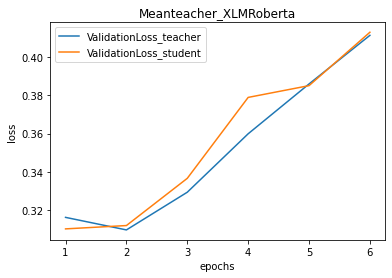

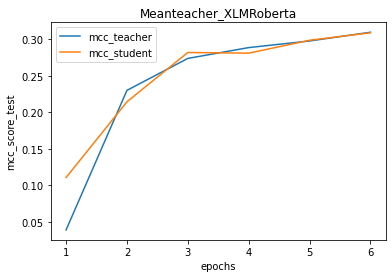

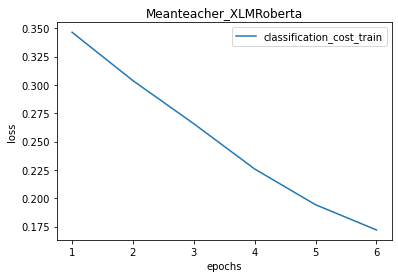

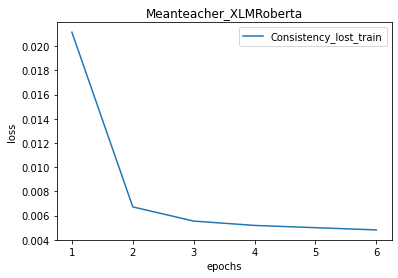

In [103]:
plot_against_epochs(test_cost_teacher,test_cost_student,label1 = 'ValidationLoss_teacher', 
                    label2 = 'ValidationLoss_student', y_label = 'loss', title ='Meanteacher_XLMRoberta' )
plot_against_epochs(mcc_cost_teacher,mcc_cost_student,label1 = 'mcc_teacher', 
                    label2 = 'mcc_student', y_label = 'mcc_score_test', title ='Meanteacher_XLMRoberta' )
plot_against_epochs(classification_cost_lst,None,label1 = 'classification_cost_train', 
                    label2 = None, y_label = 'loss', title ='Meanteacher_XLMRoberta' )
plot_against_epochs(consistency_cost_lst,None,label1 = 'Consistency_lost_train', 
                    label2 = None, y_label = 'loss', title ='Meanteacher_XLMRoberta' )
# Classificataion_lost_train()

<h3> Use less data to check results - with Nosie and dropout, and scaling consistency cost by 10  </h3>

In [14]:
# class AddGaussianNoise(nn.Module):
#     def __init__(self, mean=0., std=1.):
#         super().__init__()
#         self.std = std
#         self.mean = mean
        
#     def forward(self, tensor):
#         if self.training:
#             return tensor + torch.randn(tensor.size()) * self.std + self.mean
#         else:
#             return tensor
    

In [21]:
class EarlyStopping(object):
    def __init__(self, mode='max', min_delta=0, patience=10, percentage=False):
        self.mode = mode
        self.min_delta = min_delta
        self.patience = patience
        self.best = 0
        self.num_bad_epochs = 0
        self.is_better = None
        self._init_is_better(mode, min_delta, percentage)

        if patience == 0:
            self.is_better = lambda a, b: True
            self.step = lambda a: False

    def step(self, metrics):
        if self.best is None:
            self.best = metrics
            return False

        if np.isnan(metrics):
            return True

        if self.is_better(metrics, self.best):
            self.num_bad_epochs = 0
            self.best = metrics
        else:
            self.num_bad_epochs += 1

        if self.num_bad_epochs >= self.patience:
            print('terminating because of early stopping!')
            return True

        return False

    def _init_is_better(self, mode, min_delta, percentage):
        if mode not in {'min', 'max'}:
            raise ValueError('mode ' + mode + ' is unknown!')
        if not percentage:
            if mode == 'min':
                self.is_better = lambda a, best: a < best 
            if mode == 'max':
                self.is_better = lambda a, best: a > best 
        else:
            if mode == 'min':
                self.is_better = lambda a, best: a < best - (
                            best * min_delta / 100)
            if mode == 'max':
                self.is_better = lambda a, best: a > best + (
                            best * min_delta / 100)

In [64]:
param_optimizer = list(model.named_parameters())
no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
optimizer_parameters = [
    {
        "params": [
            p for n, p in param_optimizer if not any(nd in n for nd in no_decay)
        ],
        "weight_decay": 0.001,
    },
    {
        "params": [
            p for n, p in param_optimizer if any(nd in n for nd in no_decay)
        ],
        "weight_decay": 0.0,
    },
]
num_train_steps = int(len(syn_dataset) / config.TRAIN_BATCH_SIZE * config.EPOCHS) #10 is the batchsize
optimizer = AdamW(optimizer_parameters, lr=2e-5) # used 3e-5
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=0, num_training_steps=num_train_steps
)
# early_stopping = EarlyStopping(patience=4)

NameError: name 'syn_dataset' is not defined

In [23]:
config.EPOCHS

20

In [25]:
for name,param in model.named_parameters():
    if 'classifier' not in name:
        param.requires_grad = True